In [126]:
import numpy as np
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import csv
from scipy.stats import norm
import seaborn as sns
from pathlib import Path
import os

In [127]:
# adding average HFO duration as another column in participants

# change this function to change the dependent variable (e.g. duration, count. etc.)
def avgduration(subjn, runn):
    subjectfile = f'dataset/derivatives/sub-{subjn}/ses-01/eeg/sub-{subjn}_ses-01_task-hfo_run-0{runn}_events.tsv'
    df = pd.read_csv(subjectfile, sep='\t', header=0)
    return df.loc[:, 'indDuration'].mean()

nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
avgdurations = [] #rename this according to what variable you're looking at
for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(f'dataset/derivatives/sub-{subj}/ses-01/eeg/sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + avgduration(subj, i) #change "avgduration" to match function above
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    avgdurations.append(int(avg)) #rename this to match array above

for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(f'dataset/derivatives/sub-{subj}/ses-01/eeg/sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + avgduration(subj, i) #change this to match function above
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    avgdurations.append(int(avg)) #rename this to match array above

participants = pd.read_csv('dataset/participants.tsv', sep='\t', header=0)
participants['HFODuration'] = avgdurations #rename this to whatever variable you're looking at + the array, be sure to stack (see count vs. age below)
participants.to_csv('participants.csv', index=False)
participants = pd.read_csv('participants.csv')



In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import truncnorm, ks_2samp, kstest, norm
from scipy.optimize import minimize

In [129]:
alpha = 0.05


def getecdf(samples):
    xs = np.sort(samples)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    return xs, ys


def ks_normality_test(x, label):
    mu, sigma = x.mean(), x.std(ddof=0)
    ks_stat, p_val = kstest(x, 'norm', args=(mu, sigma))
    is_normal = p_val >= alpha
    print(f"[Normality] {label}: KS={ks_stat:.4f}, p={p_val:.4g} "
          f"→ Is normal? {'Yes' if is_normal else 'No'}")
    # plot eCDF vs fitted Normal CDF
    xs, ys = getecdf(x)
    plt.figure(figsize=(6,4))
    plt.step(xs, ys, where='post', label=f"{label} eCDF")
    plt.plot(xs, norm.cdf(xs, loc=mu, scale=sigma),
             lw=1.8, label=f"Normal(μ̂,σ̂) CDF")
    plt.title(f"{label}: eCDF vs fitted Normal\nIs normal? "
              f"{'Yes' if is_normal else 'No'} (α={alpha})")
    plt.xlabel("HFO duration (ms)"); plt.ylabel("CDF"); plt.legend(); plt.tight_layout()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

# Duration vs. Age

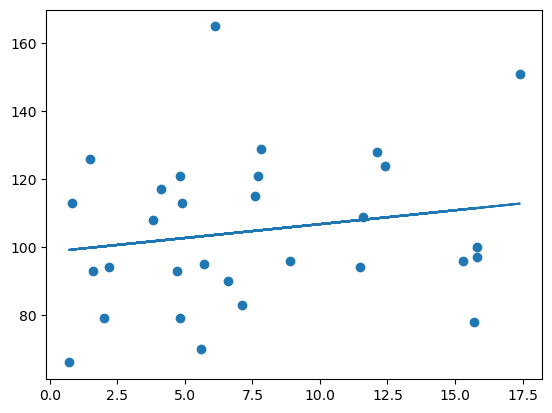

R² = 0.0325


In [130]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))


plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

# r^2

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Calculate R^2
r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")

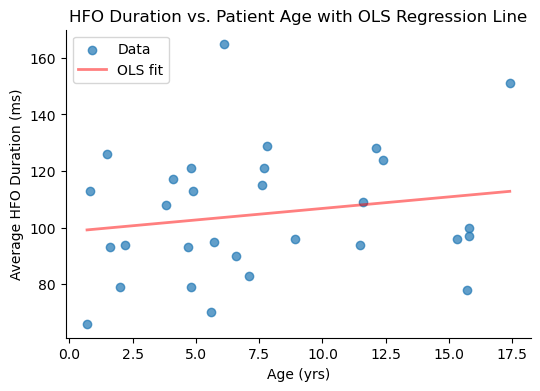

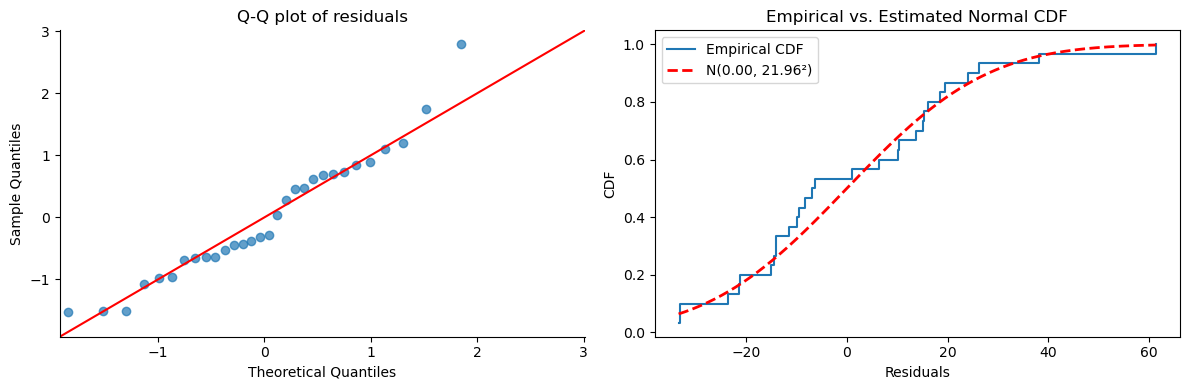

In [131]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 

df = participants

X_sm = sm.add_constant(df['age'])  
#print(df)     # add intercept
model = sm.OLS(df['HFODuration'], X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(df['age'], df['HFODuration'], alpha=0.7, label='Data')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
x_vals = np.linspace(df['age'].min(), df['age'].max(), 100)
y_vals = model.params['const'] + model.params['age'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit', alpha = 0.5)
plt.xlabel('Age (yrs)')
plt.ylabel('Average HFO Duration (ms)')
plt.title('HFO Duration vs. Patient Age with OLS Regression Line')
plt.legend(loc='upper left')
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')
sns.despine(ax = axes[0])

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

In [132]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
x = participants['age'].to_numpy()
y = participants['HFODuration'].to_numpy() #dependent variable, change 
x = x.reshape(-1, 1)

df = participants



bootstraps = 1000
boots = []

for _ in range(bootstraps):
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_sample = x[indices]
    y_sample = y[indices]

    model = LinearRegression().fit(x_sample, y_sample)
    boots.append(model.coef_[0])  # Save the slope


slopes = np.array(boots)

lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)

print(f"95% CI for the slope: ({lower:.4f}, {upper:.4f})")

95% CI for the slope: (-0.9083, 2.5634)


[Normality] HFOduration: KS=0.1361, p=0.5879 → Is normal? Yes


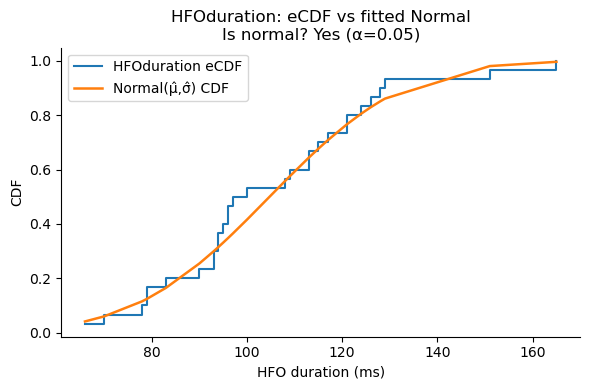

In [133]:
y = participants['HFODuration']

ks_normality_test(y, 'HFOduration')

# Duration vs. Sex

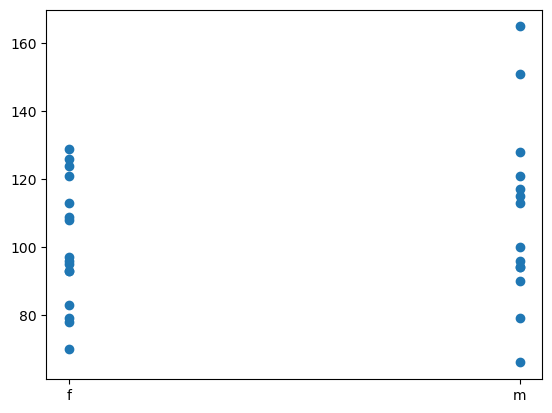

In [134]:
#regression graph of duration vs. sex

import matplotlib.pyplot as plt
from scipy import stats

x = participants['sex']
y = participants['HFODuration']

plt.scatter(x, y)
plt.show()

# bootstrap scipy.optimize

# Count vs Age

In [135]:
def hfocount(subjn, runn):
    subjectfile = f'dataset/derivatives/sub-{subjn}/ses-01/eeg/sub-{subjn}_ses-01_task-hfo_run-0{runn}_events.tsv'
    df = pd.read_csv(subjectfile, sep='\t', header=0)
    return df['nChannel'].count()

nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
hfocounts = []
for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(f'dataset/derivatives/sub-{subj}/ses-01/eeg/sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + hfocount(subj, i)
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    hfocounts.append(int(avg))

for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(f'dataset/derivatives/sub-{subj}/ses-01/eeg/sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + hfocount(subj, i)
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    hfocounts.append(int(avg))

participants = pd.read_csv('dataset/participants.tsv', sep='\t', header=0)
participants['HFODuration'] = avgdurations #be sure to stack!!
participants['hfocount'] = hfocounts
participants.to_csv('participants.csv', index=False)
participants = pd.read_csv('participants.csv')

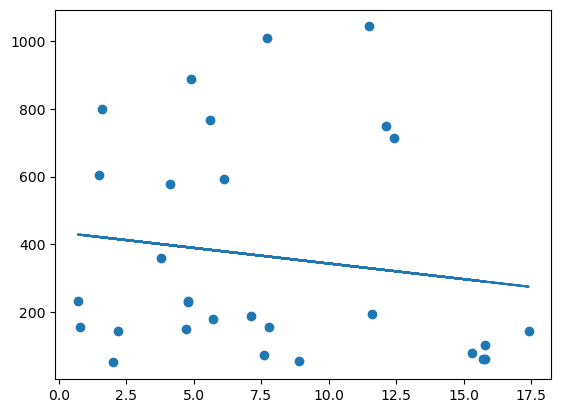

R² = 0.0212


In [136]:


x = participants['age']
y = participants['hfocount']


q1, q3 = participants['hfocount'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))


plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

# r^2

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Calculate R^2
r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")

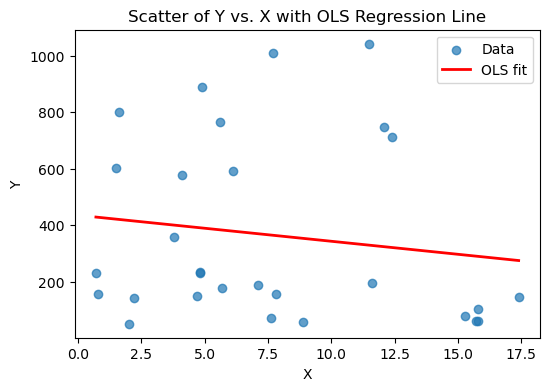

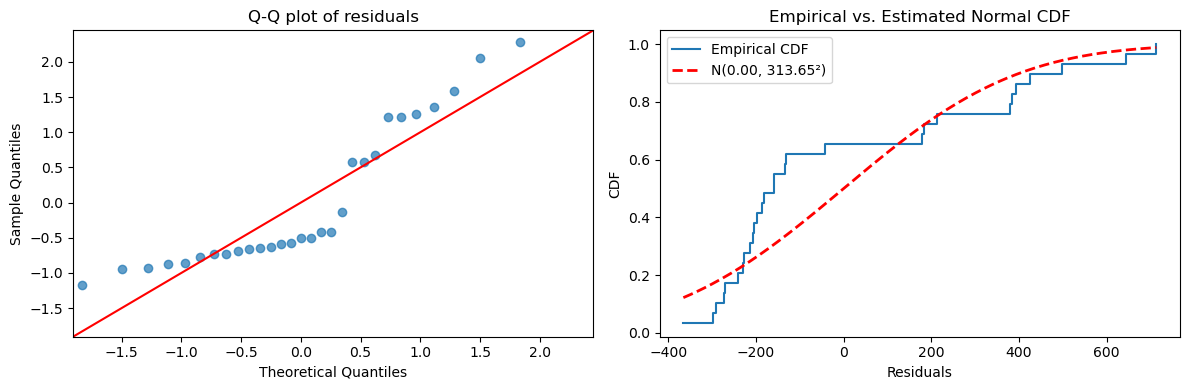

In [137]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['hfocount'] #dependent variable, change 

x = participants['age']
y = participants['hfocount']


q1, q3 = participants['hfocount'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

df = participants

X_sm = sm.add_constant(x)  
#print(df)     # add intercept
model = sm.OLS(y, X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7, label='Data')
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = model.params['const'] + model.params['age'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

[Normality] count: KS=0.2826, p=0.01532 → Is normal? No


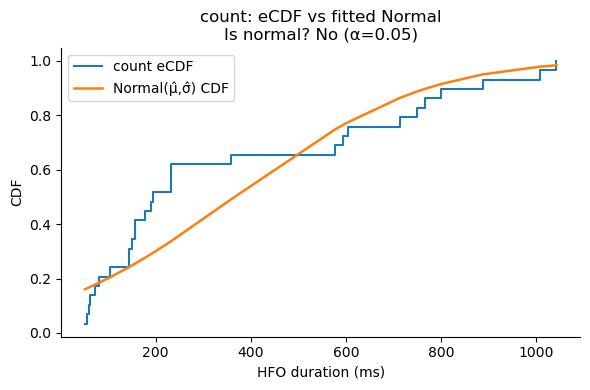

In [138]:
ks_normality_test(y, "count")